# Anomaly Detection

This notebook analyzes a dataset on global electricity usage.


## Import libraries

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load the data

In [6]:
data_path = 'test.csv'

data = pd.read_csv(data_path)

## Understanding the data

The data is split into 9 columns;

* **Date**: The date of the data collection. There are 24 entries per date, one every hour.
* **Time**: The time of the data collection. Data was recorded every hour.
* **Global_active_power**: 
* **Voltage**:
* **Global_intensity**:
* **Sub_metering_1**:
* **Sub_metering_2**:
* **Sub_metering_3**:

In [7]:
data.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,1/12/2009,14:07:00,0.61735,0.242,246.22,3.2,0.0,0.0,6.0
1,1/12/2009,14:08:00,0.64060,0.312,244.77,5.6,0.0,0.0,10.0
2,1/12/2009,14:09:00,0.66985,0.310,245.03,6.4,0.0,0.0,11.0
3,1/12/2009,14:10:00,1.58400,0.312,245.53,6.6,0.0,0.0,11.0
4,1/12/2009,14:11:00,1.46800,0.224,245.96,6.0,0.0,0.0,11.0


## A quick look at the first 10 days

Global Active Power vs Time for the first 10 days (24 hours * 10 days per 24 hours)

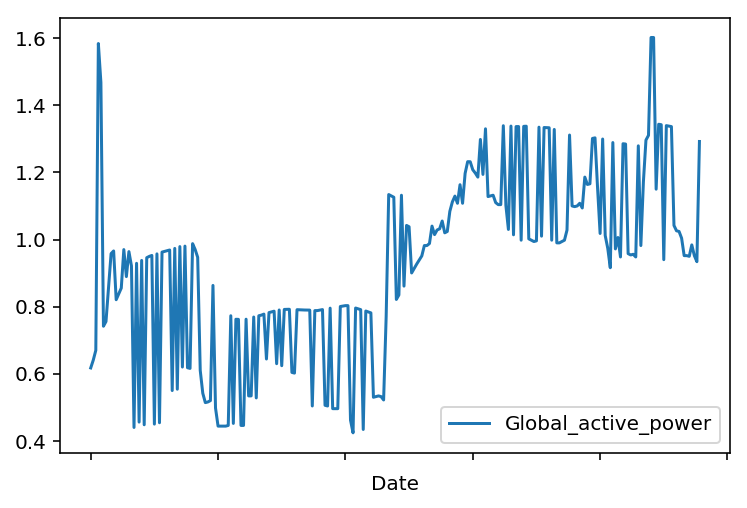

In [8]:
data[:24*10].plot(x='Date', y='Global_active_power')